In [1]:
!pip install matplotlib==3.4.0

In [2]:
!pip install little-mallet-wrapper

In [3]:
import os
import re
from collections import Counter
import little_mallet_wrapper as lmw
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from google.colab import drive, files

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# point to the drive directory
endo_dir = '/content/drive/MyDrive/endometriosis/'

In [6]:
dataset_file = os.path.join(endo_dir, 'data','endo+endometriosis.pkl')
data_df = pd.read_pickle(dataset_file)
data_df['year'] = [int(str(x).split('-')[0]) for x in data_df.time]
print(len(data_df))
data_df[:1]

392087


,author,id,type,text,url,link_id,parent_id,flair,subreddit,created_utc,time,year
0,endogirl,Endo_c3efp47_comment,comment,Soy is a no go as it increases estrogen in you...,http://www.reddit.com/r/Endo/comments/mrkjh/,t3_mrkjh,t1_c39qhd9,N/A,Endo,1325832269,2012-01-06 06:44:29,2012


In [7]:
old_data_df = data_df
len(old_data_df)

392087

In [8]:
indexes = []
for index, row in data_df.iterrows():
  if row['text'] == '[deleted]' or row['text'] == '[removed]':
    indexes.append(index)
len(indexes)

4210

In [9]:
data_df = data_df.drop(indexes)
len(data_df)

387877

In [10]:
def len_docs_column(df):

  n_tokxdoc = []
  for index, row in df.iterrows():
      doc = row['text']
      tokenized_doc = lmw.process_string(doc, lowercase=False, remove_short_words=False, remove_stop_words=False, remove_punctuation=True)
      n_tokxdoc.append(len([t for t in tokenized_doc.split(' ')]))

  return n_tokxdoc

In [11]:
data_df['n_words'] = len_docs_column(data_df)

## Number of posts and comments

In [12]:
endo = data_df.loc[data_df['subreddit']=='Endo']
len(endo)

247805

In [13]:
endometriosis = data_df.loc[data_df['subreddit']=='endometriosis']
len(endometriosis)

140072

In [14]:
posts = data_df.loc[data_df['type']=='post']
len(posts)

34715

In [15]:
posts_endo = data_df.loc[data_df['subreddit']=='Endo'].loc[data_df['type']=='post']
len(posts_endo)

22584

In [16]:
posts_endometriosis = data_df.loc[data_df['subreddit']=='endometriosis'].loc[data_df['type']=='post']
len(posts_endometriosis)

12131

In [17]:
comments = data_df.loc[data_df['type']=='comment']
len(comments)

353162

In [18]:
comments_endo = data_df.loc[data_df['subreddit']=='Endo'].loc[data_df['type']=='comment']
len(comments_endo)

225221

In [19]:
comments_endometriosis = data_df.loc[data_df['subreddit']=='endometriosis'].loc[data_df['type']=='comment']
len(comments_endometriosis)

127941

In [20]:
posts['n_words'].median()

133.0

In [21]:
print(f'Median number of Words in Posts:\t\t\t{posts.n_words.median()}')
print(f'Median number of Words in Posts in r/Endo:\t\t{posts_endo.n_words.median()}')
print(f'Median number of Words in Posts in r/endometriosis:\t{posts_endometriosis.n_words.median()}')
print(f'Median number of Words in Comments:\t\t\t{comments.n_words.median()}')
print(f'Median number of Words in Comments in r/Endo:\t\t{comments_endo.n_words.median()}')
print(f'Median number of Words in Comments in r/endometriosis:\t{comments_endometriosis.n_words.median()}')

Median number of Words in Posts:			133.0
Median number of Words in Posts in r/Endo:		134.0
Median number of Words in Posts in r/endometriosis:	131.0
Median number of Words in Comments:			43.0
Median number of Words in Comments in r/Endo:		44.0
Median number of Words in Comments in r/endometriosis:	42.0


## Figures

## Combined plots

In [24]:
posts_year_df = posts.groupby('year').count().reset_index().rename(columns = {"year":"Year", "id":"Counts"})[['Year', 'Counts']]
posts_year_df.loc[len(posts_year_df.index)] = [2013, 0]
posts_year_df = posts_year_df.sort_values('Year')

In [33]:
comments_year_df = comments.groupby('year').count().reset_index().rename(columns = {"year":"Year", "id":"Counts"})[['Year', 'Counts']]

<ipython-input-39-02e913fb637b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=posts_year_df, x='Year', y='Counts', # hue='Type',


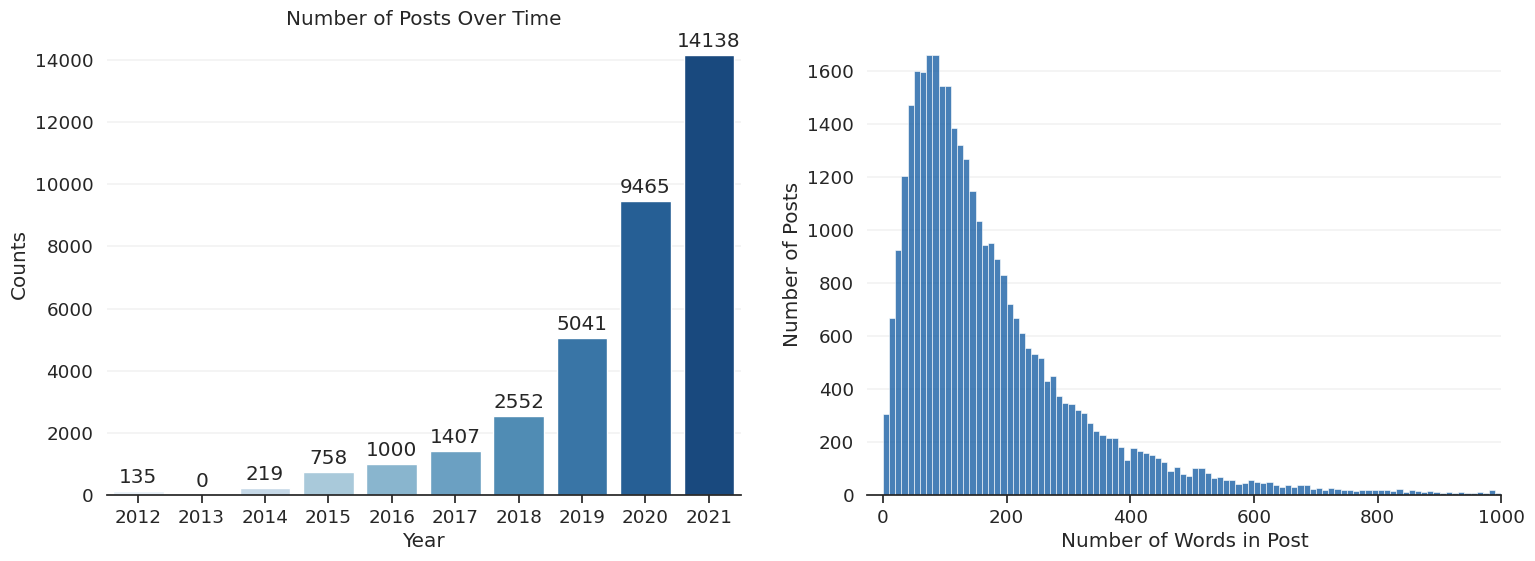

In [39]:
figure = plt.figure(figsize=(18, 6))

figure.add_subplot(1,2,1)
ax = sns.barplot(data=posts_year_df, x='Year', y='Counts', # hue='Type',
                palette=sns.color_palette("Blues", len(posts_year_df.index)),
                #palette=['royalblue' for i in range(0,len(posts_year_df.index))],
                edgecolor='white',
                errorbar=None)
for container in ax.containers:
  for v in container:
    labels = [f'{round(v.get_height())}' for v in container]
    ax.bar_label(container, labels=labels, padding=3)

# add grid
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
#plt.xticks(rotation=45, ha='right')
plt.tick_params(left=False)  # remove the ticks

# Remove top, left, right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title('Number of Posts Over Time')

figure.add_subplot(1,2,2)
color = sns.color_palette('Blues')[len(posts_year_df.index)//2]
ax = sns.histplot(data=posts, x="n_words", bins=100, binrange=(0,1000), color=color)
plt.xlim(xmin=-25,xmax=1000)
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.tick_params(left=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xlabel('Number of Words in Post')
plt.ylabel('Number of Posts')


figure.savefig(os.path.join(endo_dir, 'writing', 'JMIR', 'figures_for_JMIR', 'figure1.png'), dpi = 300, bbox_inches = "tight")
figure.show()

<ipython-input-40-6c0e5e412a6a>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=comments_year_df, x='Year', y='Counts', # hue='Type',
<ipython-input-40-6c0e5e412a6a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=comments_year_df, x='Year', y='Counts', # hue='Type',


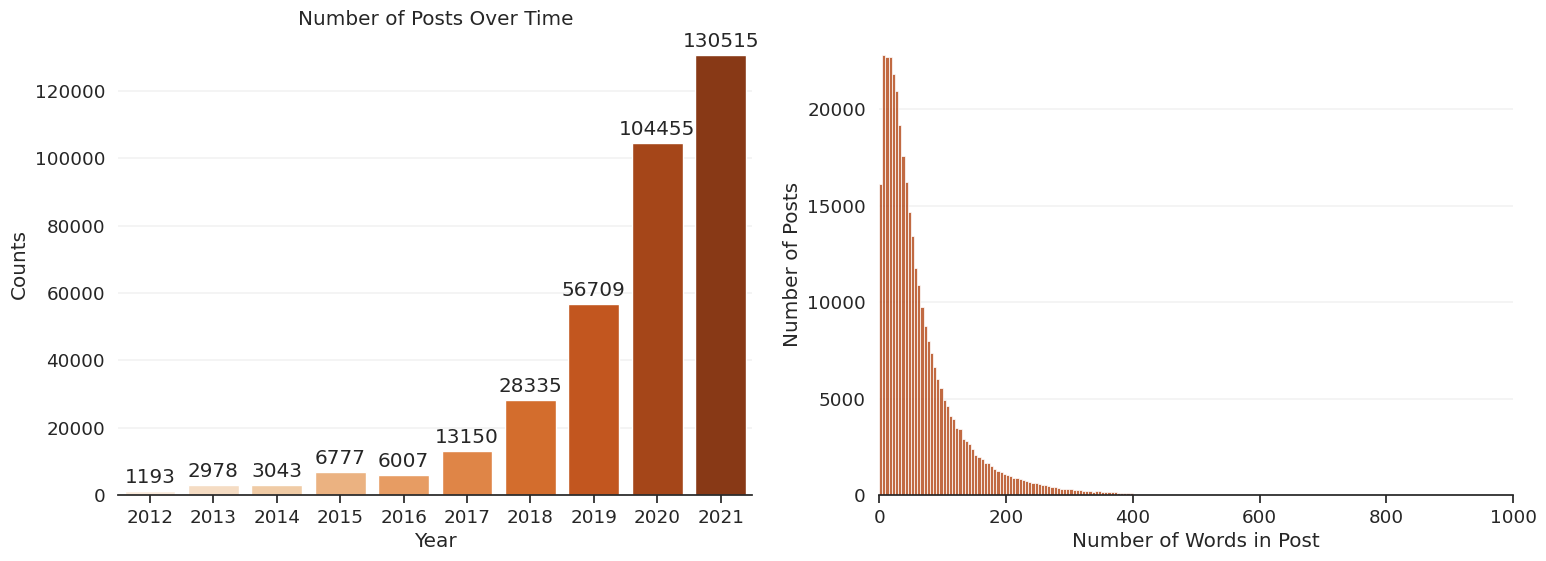

In [40]:
figure = plt.figure(figsize=(18, 6))

figure.add_subplot(1,2,1)
ax = sns.barplot(data=comments_year_df, x='Year', y='Counts', # hue='Type',
                palette=sns.color_palette("Oranges", len(comments_year_df.index)),
                edgecolor='white',
                ci=None)
for container in ax.containers:
  for v in container:
    labels = [f'{round(v.get_height())}' for v in container]
    ax.bar_label(container, labels=labels, padding=3)

# add grid
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
#plt.xticks(rotation=45, ha='right')
plt.tick_params(left=False)  # remove the ticks

# Remove top, left, right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title('Number of Posts Over Time')

figure.add_subplot(1,2,2)
color = sns.color_palette('Oranges')[len(comments_year_df.index)//2]
ax = sns.histplot(data=comments, x="n_words", bins=80, binrange=(0,400), color=color)
plt.xlim(xmin=-10,xmax=400)
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.tick_params(left=False)
ax.set_xlim(0,1000)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xlabel('Number of Words in Post')
plt.ylabel('Number of Posts')


figure.savefig(os.path.join(endo_dir, 'writing', 'JMIR', 'figures_for_JMIR', 'figure2.png'), dpi = 300, bbox_inches = "tight")
figure.show()

### Counts

#### Lineplot

In [ ]:
plt.figure(figsize=(10, 7))
ax = sns.lineplot(data=posts_year_df, x='Year', y='Counts', linewidth=3)

# add grid
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.tick_params(left=False)  # remove the ticks

# Remove top, left, right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title('Number of Posts Over Time')
plt.savefig(os.path.join(endo_dir, 'data', f'posts_years2.png'), dpi = 300, bbox_inches = "tight")
plt.show()

#### Barplot

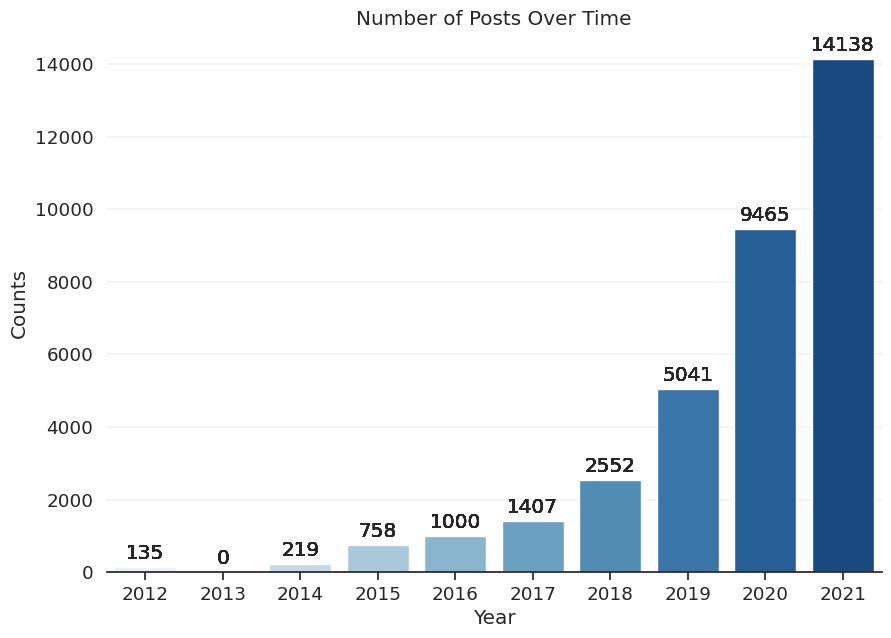

In [ ]:
plt.figure(figsize=(10, 7))
ax = sns.barplot(data=posts_year_df, x='Year', y='Counts', # hue='Type',
                palette=sns.color_palette("Blues", len(posts_year_df.index)),
                #palette=['royalblue' for i in range(0,len(posts_year_df.index))],
                edgecolor='white',
                errorbar=None)
for container in ax.containers:
  for v in container:
    labels = [f'{round(v.get_height())}' for v in container]
    ax.bar_label(container, labels=labels, padding=3)

# add grid
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
#plt.xticks(rotation=45, ha='right')
plt.tick_params(left=False)  # remove the ticks

# Remove top, left, right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title('Number of Posts Over Time')
plt.savefig(os.path.join(endo_dir, 'data', f'posts_years.png'), dpi = 300, bbox_inches = "tight")
plt.show()

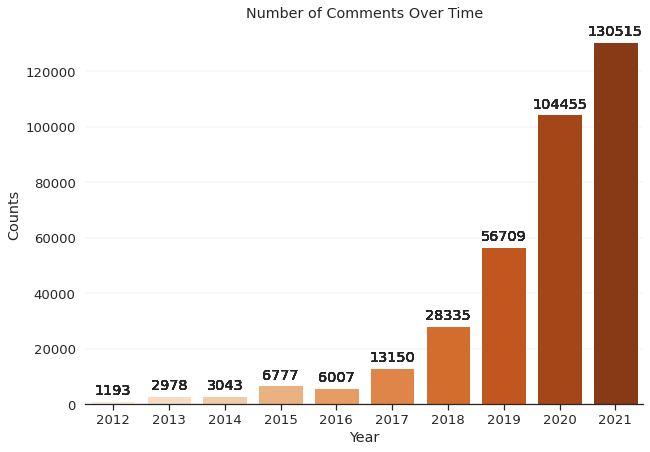

In [ ]:
plt.figure(figsize=(10, 7))
ax = sns.barplot(data=comments_year_df, x='Year', y='Counts', # hue='Type',
                palette=sns.color_palette("Oranges", len(comments_year_df.index)),
                edgecolor='white',
                ci=None)
for container in ax.containers:
  for v in container:
    labels = [f'{round(v.get_height())}' for v in container]
    ax.bar_label(container, labels=labels, padding=3)

# add grid
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
#plt.xticks(rotation=45, ha='right')
plt.tick_params(left=False)  # remove the ticks

# Remove top, left, right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title('Number of Comments Over Time')
plt.savefig(os.path.join(endo_dir, 'data', f'comments_years.png'), dpi = 300, bbox_inches = "tight")
plt.show()

### Length

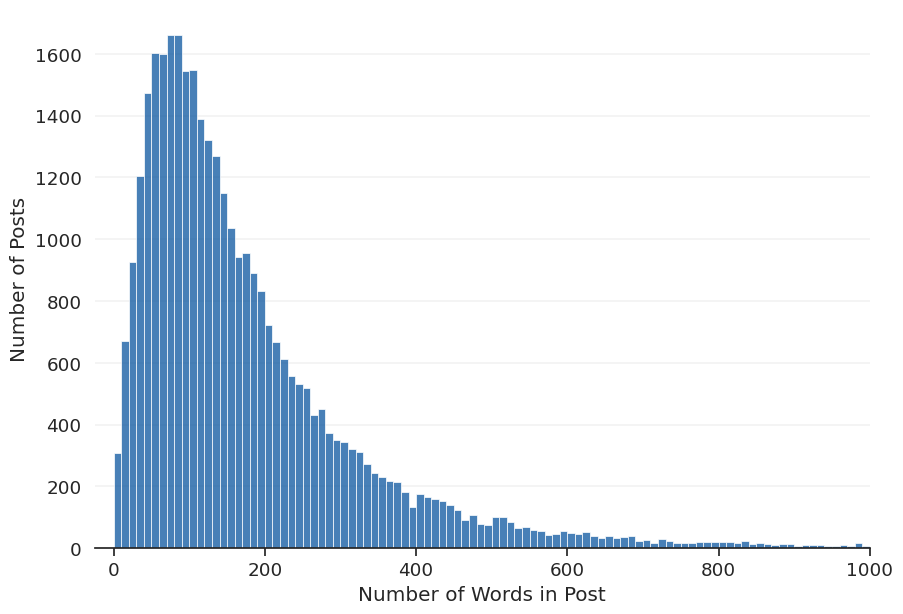

In [ ]:
plt.figure(figsize=(10, 7))
color = sns.color_palette('Blues')[len(posts_year_df.index)//2]
ax = sns.histplot(data=posts, x="n_words", bins=100, binrange=(0,1000), color=color)
plt.xlim(xmin=-25,xmax=1000)
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.tick_params(left=False)
#ax.set_ylim(0, 22000)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xlabel('Number of Words in Post')
plt.ylabel('Number of Posts')
plt.savefig(os.path.join(endo_dir, 'data', f'len_posts.png'), dpi = 500, bbox_inches = "tight")
plt.show()

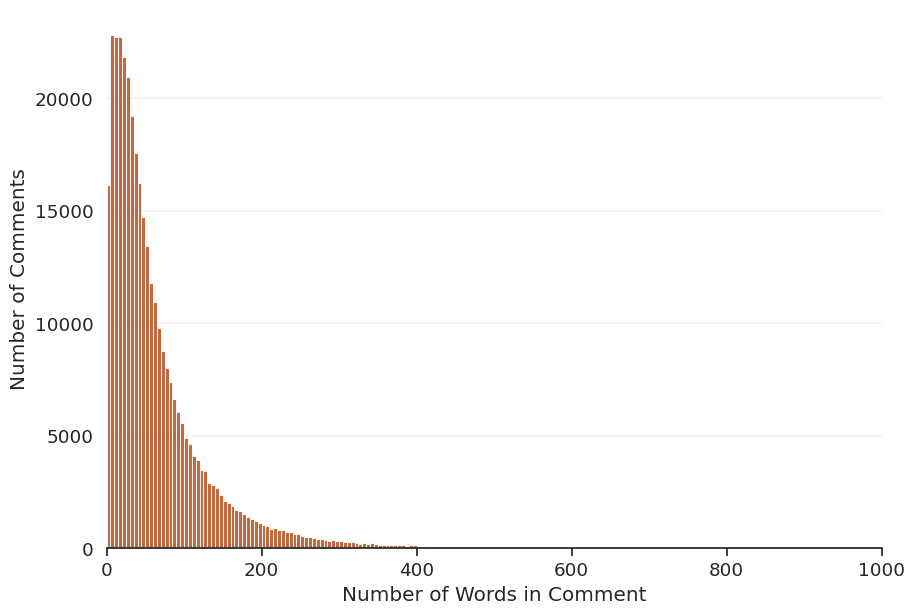

In [ ]:
plt.figure(figsize=(10, 7))
color = sns.color_palette('Oranges')[len(comments_year_df.index)//2]
ax = sns.histplot(data=comments, x="n_words", bins=80, binrange=(0,400), color=color)
plt.xlim(xmin=-10,xmax=400)
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
plt.tick_params(left=False)
ax.set_xlim(0,1000)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xlabel('Number of Words in Comment')
plt.ylabel('Number of Comments')
plt.savefig(os.path.join(endo_dir, 'data', f'len_comms.png'), dpi = 300, bbox_inches = "tight")
plt.show()

## Unique authors

In [ ]:
print(f'Unique authors in r/endo : {len(data_df.author.unique())}')
print(f'Unique authors in r/endo : {len(endo.author.unique())}')
print(f'Unique authors in r/endometriosis : {len(endometriosis.author.unique())}')

Unique authors in r/endo : 29783


NameError: ignored

In [ ]:
print(f'Common authors: {len(np.intersect1d(endo.author.unique().tolist(), endometriosis.author.unique().tolist()))}')

Common authors: 7631


In [ ]:
posts.groupby('author').count().drop('[deleted]').id.mean()

2.320075122409283

In [ ]:
posts_endo.groupby('author').count().drop('[deleted]').id.mean()

2.278498985801217

In [ ]:
posts_endometriosis.groupby('author').count().drop('[deleted]').id.mean()

1.6966134900643717

In [ ]:
comments.groupby('author').count().drop('[deleted]').id.mean()

12.938674398120963

In [ ]:
comments_endo.groupby('author').count().drop('[deleted]').id.mean()

12.121622350466534

In [ ]:
comments_endometriosis.groupby('author').count().drop('[deleted]').id.mean()

8.126017293997965

## Removed posts and comments

In [ ]:
flag = 0
for index, row in data_df.loc[data_df['type']=='post'].iterrows():
  if row['text'] == '[deleted]' or row['text'] == '[removed]':
    flag+=1

flag

0

In [ ]:
flag = 0
for index, row in data_df.loc[data_df['type']=='comment'].iterrows():
  if row['text'] == '[deleted]' or row['text'] == '[removed]':
    flag+=1

flag

4210

In [ ]:
flag = 0
for index, row in data_df.loc[data_df['subreddit']=='Endo'].loc[data_df['type']=='comment'].iterrows():
  if row['text'] == '[deleted]' or row['text'] == '[removed]':
    flag+=1

flag

3002

In [ ]:
flag = 0
for index, row in data_df.loc[data_df['subreddit']=='endometriosis'].loc[data_df['type']=='comment'].iterrows():
  if row['text'] == '[deleted]' or row['text'] == '[removed]':
    flag+=1

flag

1208

## Length of posts and comments, total words, unique words



In [ ]:
def cleaning_docs(df):

    tokenized_docs = []
    n_tokxdoc = []
    vocab = Counter()
    flag = 0
    for index, row in df.iterrows():
        doc = row['text']
        #if row['text'] != '[deleted]' and row['text'] != '[removed]':
        tokenized_doc = lmw.process_string(doc, lowercase=False, remove_short_words=False, remove_stop_words=False, remove_punctuation=True)
        tokenized_doc_l = [t for t in tokenized_doc.split(' ')]
        n_tokxdoc.append(len(tokenized_doc_l))
        if tokenized_doc:
            vocab.update(tokenized_doc_l)
            tokenized_docs.append(tokenized_doc)
        else:
            flag += 1

    print("Number of Clean Documents: {}".format(len(tokenized_docs)))
    print("Number of Empty Documents: {}".format(flag))
    print("Mean Number of Words per Document: {}".format(np.mean(n_tokxdoc)))
    print("Total number of words: {}".format(sum(vocab.values())))
    print("Vocabulary Size: {}".format(len(vocab.keys())))

In [ ]:
print('ENDO+ENDOMETRIOSIS__________________')
cleaning_docs(data_df)
print('ENDO________________________________')
cleaning_docs(endo)
print('ENDOMETRIOSIS_______________________')
cleaning_docs(endometriosis)

ENDO+ENDOMETRIOSIS__________________
Number of Clean Documents: 387328
Number of Empty Documents: 549
Mean Number of Words per Document: 77.26827061155986
Total number of words: 29970036
Vocabulary Size: 138106
ENDO________________________________
Number of Clean Documents: 247420
Number of Empty Documents: 385
Mean Number of Words per Document: 78.14322552006618
Total number of words: 19363897
Vocabulary Size: 110055
ENDOMETRIOSIS_______________________
Number of Clean Documents: 139908
Number of Empty Documents: 164
Mean Number of Words per Document: 75.72036524073334
Total number of words: 10606139
Vocabulary Size: 76379


In [ ]:
#posts
print('ENDO+ENDOMETRIOSIS__________________')
cleaning_docs(posts)
print('ENDO________________________________')
cleaning_docs(posts_endo)
print('ENDOMETRIOSIS_______________________')
cleaning_docs(posts_endometriosis)

ENDO+ENDOMETRIOSIS__________________
Number of Clean Documents: 34703
Number of Empty Documents: 12
Mean Number of Words per Document: 183.6002016419415
Total number of words: 6373669
Vocabulary Size: 53076
ENDO________________________________
Number of Clean Documents: 22576
Number of Empty Documents: 8
Mean Number of Words per Document: 184.3292153737159
Total number of words: 4162883
Vocabulary Size: 44013
ENDOMETRIOSIS_______________________
Number of Clean Documents: 12127
Number of Empty Documents: 4
Mean Number of Words per Document: 182.24301376638365
Total number of words: 2210786
Vocabulary Size: 31163


In [ ]:
#comments
print('ENDO+ENDOMETRIOSIS__________________')
cleaning_docs(comments)
print('ENDO________________________________')
cleaning_docs(comments_endo)
print('ENDOMETRIOSIS_______________________')
cleaning_docs(comments_endometriosis)

ENDO+ENDOMETRIOSIS__________________
Number of Clean Documents: 352625
Number of Empty Documents: 537
Mean Number of Words per Document: 66.81609006631517
Total number of words: 23596367
Vocabulary Size: 123266
ENDO________________________________
Number of Clean Documents: 224844
Number of Empty Documents: 377
Mean Number of Words per Document: 67.4954422544967
Total number of words: 15201014
Vocabulary Size: 98034
ENDOMETRIOSIS_______________________
Number of Clean Documents: 127781
Number of Empty Documents: 160
Mean Number of Words per Document: 65.62019211980522
Total number of words: 8395353
Vocabulary Size: 68604


## Number of comments per post

In [ ]:
data_df.groupby('link_id').count().iloc[1:]['id'].mean()

8.638780851740417

In [ ]:
endo.groupby('link_id').count().iloc[1:]['id'].mean()

8.437139432082116

In [ ]:
endometriosis.groupby('link_id').count().iloc[1:]['id'].mean()

9.018185662930852

## Topic modeling file

In [ ]:
#Load topic modeling file
topic_model_file = os.path.join(endo_dir, 'output', 'topic-modeling', 'parags', 'endo+endometriosis-25_10.pkl')
tomo_df = pd.read_pickle(topic_model_file).reset_index().rename(columns = {"index":"id"}) # change index into column

# add column with info about where the paragraph comes from, whether post or comment
tomo_df['og_id'] = ['_'.join(x.split('_')[:3]) for x in tomo_df.id]

# group paragraphs' distributions by the post/comment the paragraph comes from, taking the average of the distributions
type_df = tomo_df.groupby(['og_id'], sort=False).mean().reset_index().rename(columns = {"og_id":"id"}).drop(columns=['dominant_topic'])
type_df['type'] = [x.split('_')[2] for x in type_df.id]
print(len(type_df))

334042


In [ ]:
len(type_df.loc[type_df['type']=='post'])

34190

In [ ]:
len(type_df.loc[type_df['type']=='comment'])

299852